# Credit Fraud Transaction Classification

## 0. Preparation

In [287]:
import pandas as pd
import numpy as numpy

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            roc_auc_score, roc_curve, auc, \
                            classification_report, confusion_matrix, ConfusionMatrixDisplay

In [288]:
# read data from csv to pandas dataframe
file_path = '/content/CreditCardData.csv'
df_data = pd.read_csv(file_path)

df_data.head()

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,#3577 209,14-Oct-20,Wednesday,19,Visa,Tap,£5,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25.2,RBS,0
1,#3039 221,14-Oct-20,Wednesday,17,MasterCard,PIN,£288,POS,Services,USA,USA,USA,F,49.6,Lloyds,0
2,#2694 780,14-Oct-20,Wednesday,14,Visa,Tap,£5,POS,Restaurant,India,India,India,F,42.2,Barclays,0
3,#2640 960,13-Oct-20,Tuesday,14,Visa,Tap,£28,POS,Entertainment,United Kingdom,India,United Kingdom,F,51.0,Barclays,0
4,#2771 031,13-Oct-20,Tuesday,23,Visa,CVC,£91,Online,Electronics,USA,USA,United Kingdom,M,38.0,Halifax,1


In [289]:
df_data.shape

(100000, 16)

## 1. Data Preparation

### 1.1. Dropping unnecessary columns

In [290]:
unnecessary_columns = ['Transaction ID', 'Date']

df_data.drop(unnecessary_columns, axis=1, inplace=True)

### 1.2. Missing data

Since the number of missing data is not significant, the data point will be dropped.

In [291]:
# drop missing data
df_data.dropna(inplace=True)

### 1.3. Correcting data types and values

In [292]:
# modified amount data
df_data['Amount'] = df_data['Amount'].str.replace('£','').astype(float)

df_data['Amount'].head(3)

,Amount
0,5.0
1,288.0
2,5.0


In [293]:
# modified typo values
df_data['Bank'] = df_data['Bank'].replace('Barlcays', 'Barclays')

df_data['Bank'].unique()

array(['RBS', 'Lloyds', 'Barclays', 'Halifax', 'Monzo', 'HSBC', 'Metro'],
      dtype=object)

### 1.4. Data imbalance (resampling)

The number of positive cases in the dataset is much smaller compared to the number of negative cases, leading to class imbalance.

In [294]:
resampler = RandomUnderSampler(random_state=42, sampling_strategy='majority')

X = df_data.drop('Fraud', axis=1)
y = df_data['Fraud']

X_res, y_res = resampler.fit_resample(X,y)

df_data_res = pd.DataFrame(X_res, columns = X.columns)
df_data_res['Fraud'] = y_res

print(f'''
Data dimension after resampling

Total number of rows: {df_data_res.shape[0]}
Total number of cols: {df_data_res.shape[1]}
''')


Data dimension after resampling

Total number of rows: 14384
Total number of cols: 14



In [295]:
nominal_feature = []

for col in df_data_res.columns:
    if df_data_res[col].dtype == 'object':
        nominal_feature.append(col)

In [296]:
encoder = OneHotEncoder(sparse_output=False, drop='first')

df_data_res_encoded = encoder.fit_transform(df_data_res[nominal_feature])

In [297]:
nom_feature_names = encoder.get_feature_names_out(nominal_feature)

df_data_res_enc = pd.DataFrame(df_data_res_encoded, columns=nom_feature_names, index=df_data_res.index)
df_data_res_enc = pd.concat([df_data_res.drop(nominal_feature, axis=1), df_data_res_enc], axis=1)

### 1.5. Split dataset

In [298]:
X = df_data_res.drop('Fraud', axis=1)
y = df_data_res['Fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1.6. Standardize data

In [299]:
numerical_feature = X.select_dtypes(include=['int64', 'float64']).columns
numerical_feature

Index(['Time', 'Amount', 'Age'], dtype='object')

In [300]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train[numerical_feature])
X_test_std = scaler.transform(X_test[numerical_feature])

In [301]:
X_train_processed = X_train.copy()
X_train_processed[numerical_feature] = X_train_std

X_test_processed = X_test.copy()
X_test_processed[numerical_feature] = X_test_std

In [302]:
X_train_processed.head(2)

,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank
35039,Wednesday,0.882171,Visa,CVC,1.352923,Online,Gaming,USA,USA,USA,F,-0.534852,Barclays
17745,Tuesday,-0.006617,Visa,CVC,-0.521383,Online,Restaurant,Russia,Russia,Russia,M,0.823315,Barclays


### 1.7. Encode data

In [303]:
nominal_feature = X.select_dtypes(include=['object']).columns
nominal_feature

Index(['Day of Week', 'Type of Card', 'Entry Mode', 'Type of Transaction',
       'Merchant Group', 'Country of Transaction', 'Shipping Address',
       'Country of Residence', 'Gender', 'Bank'],
      dtype='object')

In [304]:
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

X_train_encoded = encoder.fit_transform(X_train[nominal_feature])
X_test_encoded = encoder.transform(X_test[nominal_feature])

In [305]:
nom_feature_names = encoder.get_feature_names_out(nominal_feature)

X_train_processed = pd.DataFrame(X_train_encoded, columns=nom_feature_names, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_encoded, columns=nom_feature_names, index=X_test.index)

In [306]:
X_train_processed.head(2)

,Day of Week_Thursday,Day of Week_Tuesday,Day of Week_Wednesday,Type of Card_Visa,Entry Mode_PIN,Entry Mode_Tap,Type of Transaction_Online,Type of Transaction_POS,Merchant Group_Electronics,Merchant Group_Entertainment,...,Country of Residence_Russia,Country of Residence_USA,Country of Residence_United Kingdom,Gender_M,Bank_HSBC,Bank_Halifax,Bank_Lloyds,Bank_Metro,Bank_Monzo,Bank_RBS
35039,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17745,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.8. Correlated features

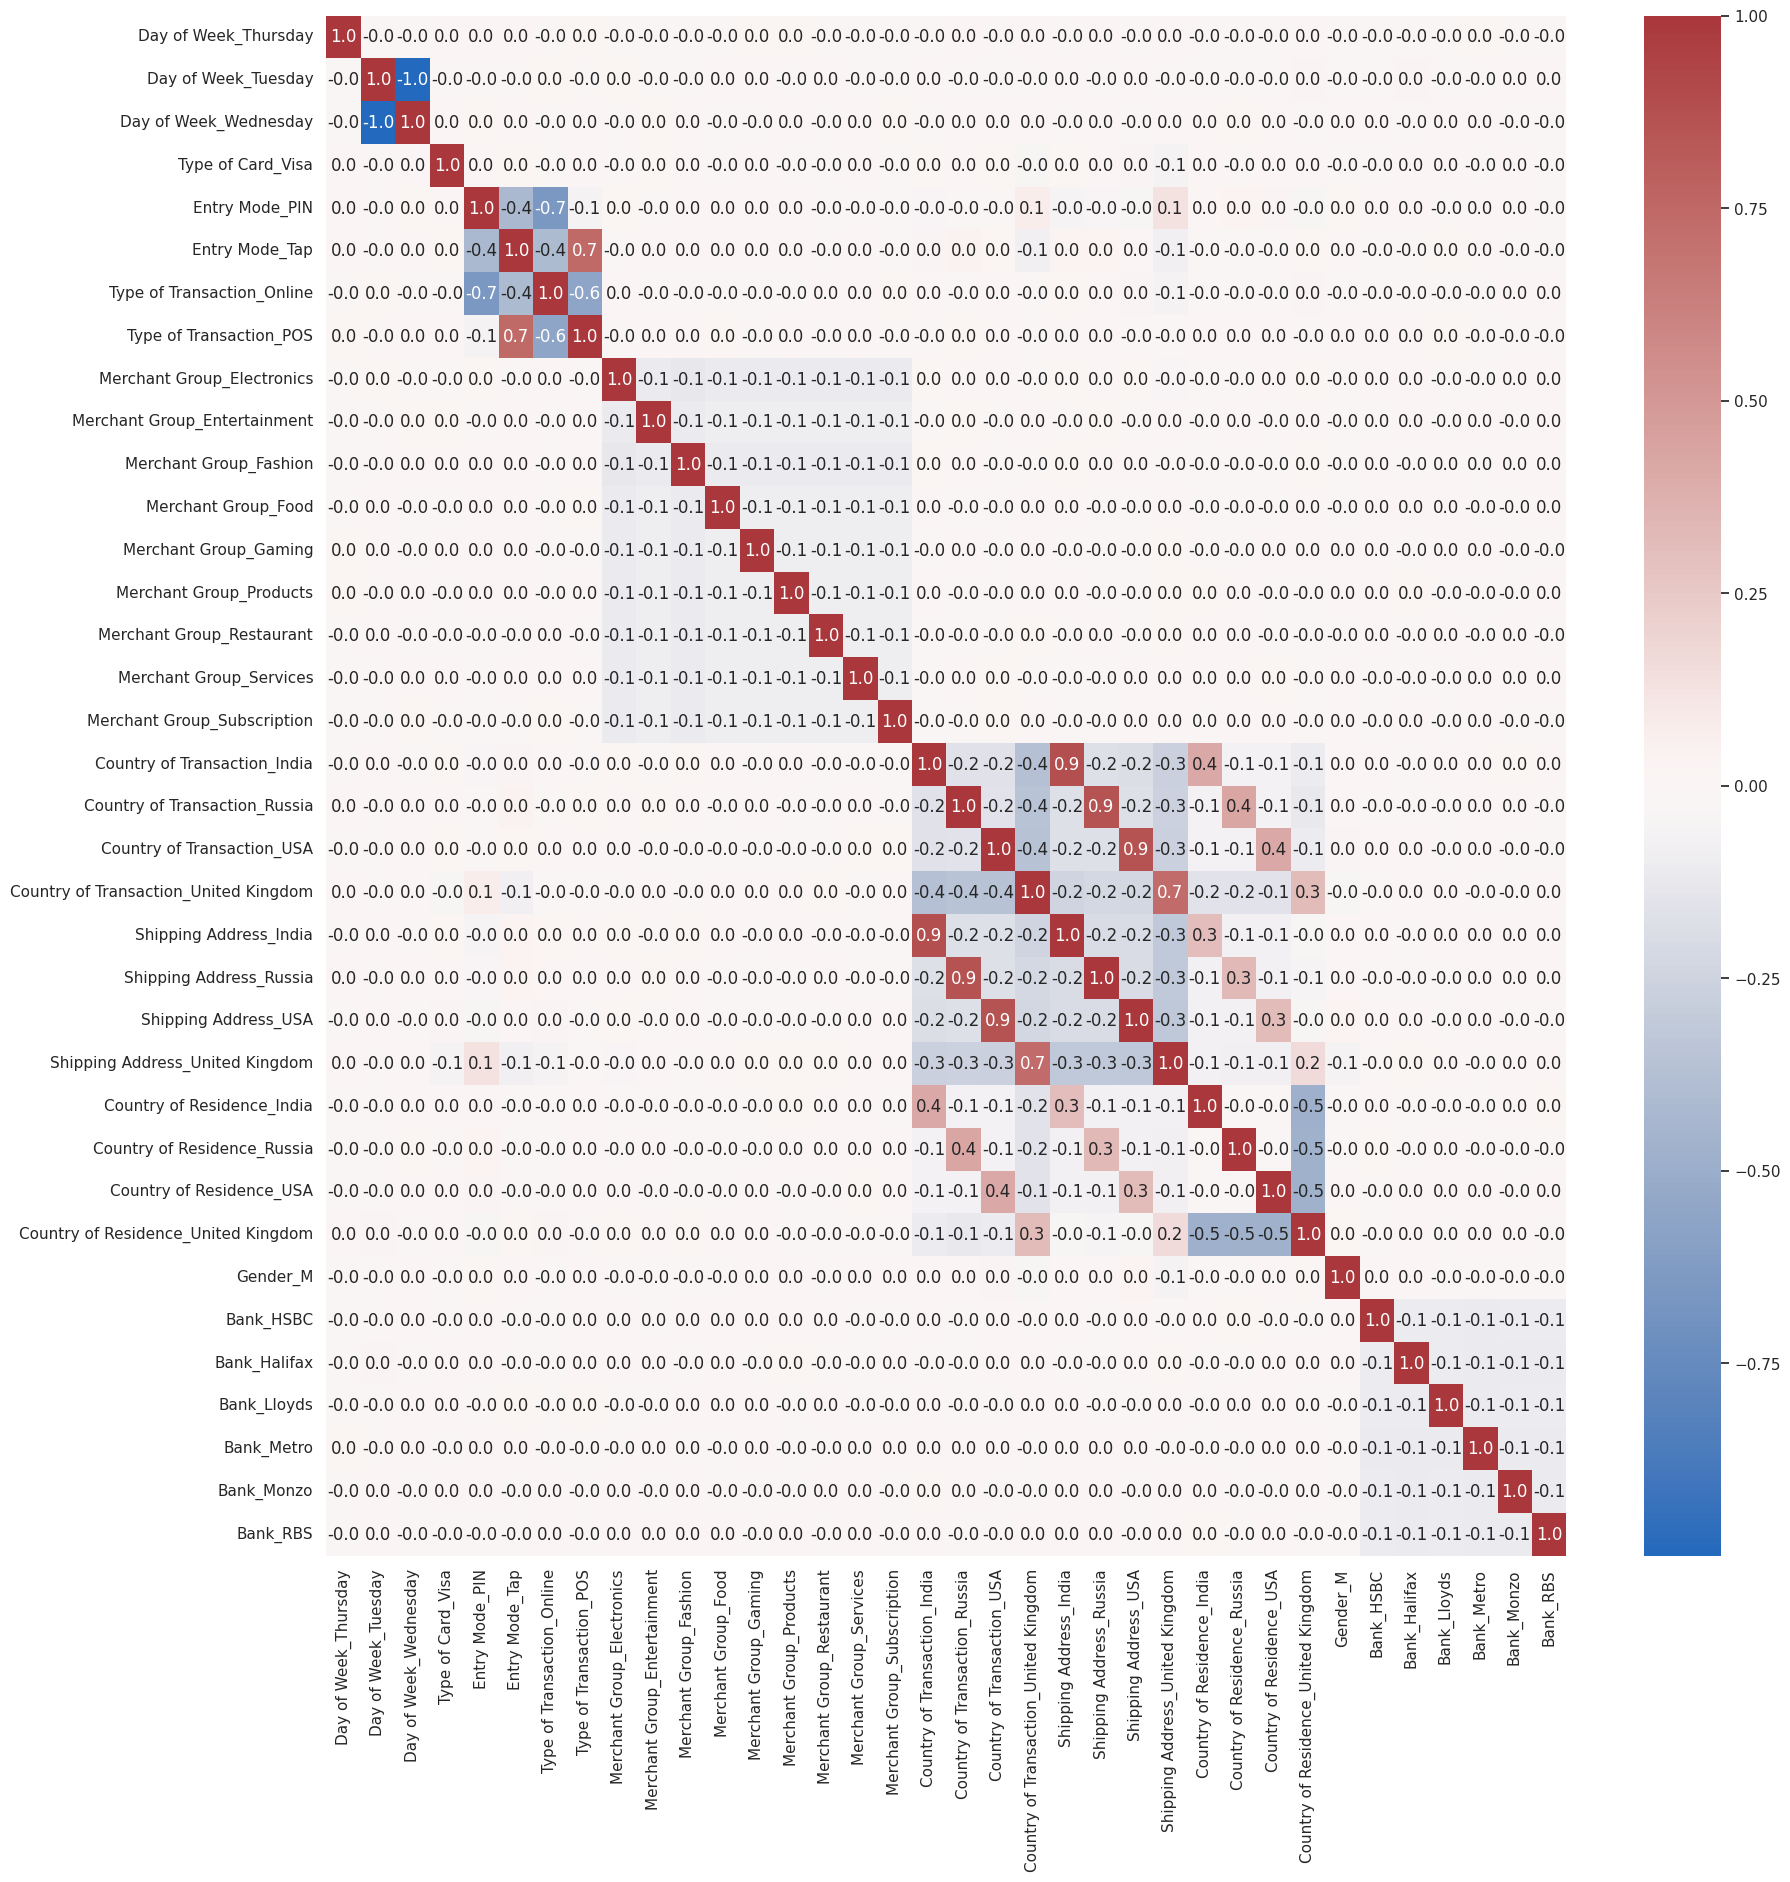

In [307]:
correlation = X_train_processed.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlation, annot=True, fmt=".1f", cmap=sns.color_palette("vlag", as_cmap=True), cbar=True)
plt.show()

In [308]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [309]:
corr_features = correlation(X_train_processed, 0.8)
print('correlated features: ', len(set(corr_features)) )

correlated features:  4


In [310]:
# drop high correlated features
X_train_processed = X_train_processed.drop(columns=corr_features, axis=1)
X_test_processed = X_test_processed.drop(columns=corr_features, axis=1)

## 2. Model training

In [311]:
def evaluation(model, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, )
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f"\n{model} Accuracy: {accuracy*100:.4f}")
    print(f"{model} Precision: {precision*100:.4f}")
    print(f"{model} Recall: {recall*100:.4f}")
    print(f"{model} F1 Score: {f1*100:.4f}")
    print(f"{model} ROC AUC Score: {roc_auc*100:.4f}")
    return accuracy, precision, recall, f1, roc_auc

def plot_confusion_matrix(model, y_true, y_pred):
    sns.heatmap(confusion_matrix(y_true, y_pred),annot=True, cmap=sns.light_palette("green", as_cmap=True), fmt='.0f')
    plt.xlabel('Predicted Values', fontdict={'size':12}, labelpad=10)
    plt.ylabel('Actual Values', fontdict={'size':12}, labelpad=10)
    plt.title(f'{model} Confusion Matrix')
    plt.show()

### 2.1. Decision tree


DecisionTreeClassifier Accuracy: 91.1018
DecisionTreeClassifier Precision: 91.0097
DecisionTreeClassifier Recall: 91.2621
DecisionTreeClassifier F1 Score: 91.1357
DecisionTreeClassifier ROC AUC Score: 91.1015

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1435
           1       0.91      0.91      0.91      1442

    accuracy                           0.91      2877
   macro avg       0.91      0.91      0.91      2877
weighted avg       0.91      0.91      0.91      2877



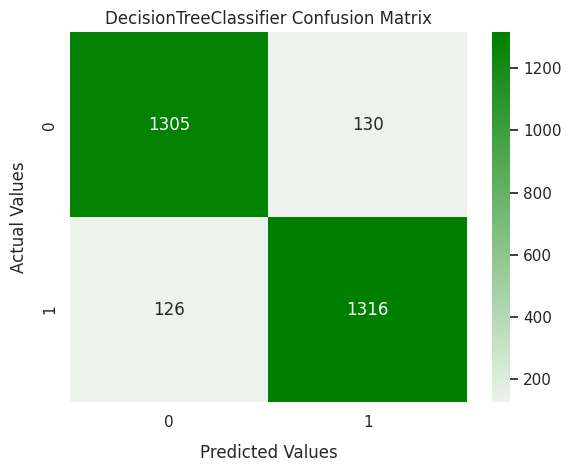

In [312]:
dt_classifier = DecisionTreeClassifier(random_state=42)

dt_classifier.fit(X_train_processed, y_train)
# Predict on the test data
y_pred = dt_classifier.predict(X_test_processed)
# Evaluate the model
dt_accuracy, dt_precision, dt_recall, dt_f1, dt_roc_auc = evaluation(dt_classifier.__class__.__name__, y_test, y_pred)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plot_confusion_matrix(dt_classifier.__class__.__name__, y_test, y_pred)

# ROC AUC
dt_fpr, dt_tpr, _ = roc_curve(y_test, y_pred)

### 2.2. KNN


KNeighborsClassifier Accuracy: 91.7970
KNeighborsClassifier Precision: 89.3090
KNeighborsClassifier Recall: 95.0069
KNeighborsClassifier F1 Score: 92.0699
KNeighborsClassifier ROC AUC Score: 91.7892

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1435
           1       0.89      0.95      0.92      1442

    accuracy                           0.92      2877
   macro avg       0.92      0.92      0.92      2877
weighted avg       0.92      0.92      0.92      2877



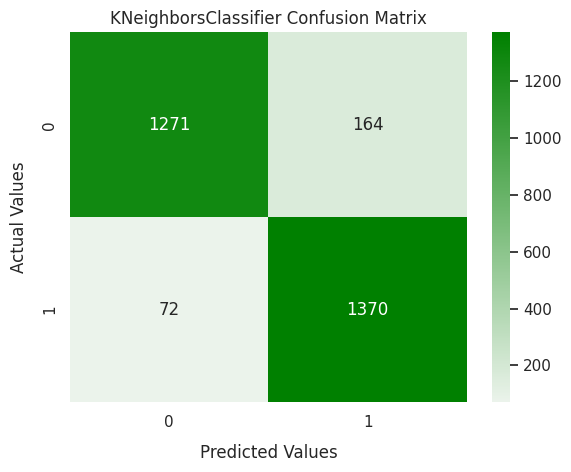

In [313]:
knn_classifier = KNeighborsClassifier(n_neighbors=3, metric="euclidean")

knn_classifier.fit(X_train_processed, y_train)
# Predict on the test data
y_pred = knn_classifier.predict(X_test_processed)
# Evaluate the model
knn_accuracy, knn_precision, knn_recall, knn_f1, knn_roc_auc = evaluation(knn_classifier.__class__.__name__, y_test, y_pred)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plot_confusion_matrix(knn_classifier.__class__.__name__, y_test, y_pred)

# ROC AUC
knn_fpr, knn_tpr, _ = roc_curve(y_test, y_pred)

### 2.3. Random forest


RandomForestClassifier Accuracy: 93.0483
RandomForestClassifier Precision: 90.6946
RandomForestClassifier Recall: 95.9778
RandomForestClassifier F1 Score: 93.2615
RandomForestClassifier ROC AUC Score: 93.0412

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1435
           1       0.91      0.96      0.93      1442

    accuracy                           0.93      2877
   macro avg       0.93      0.93      0.93      2877
weighted avg       0.93      0.93      0.93      2877



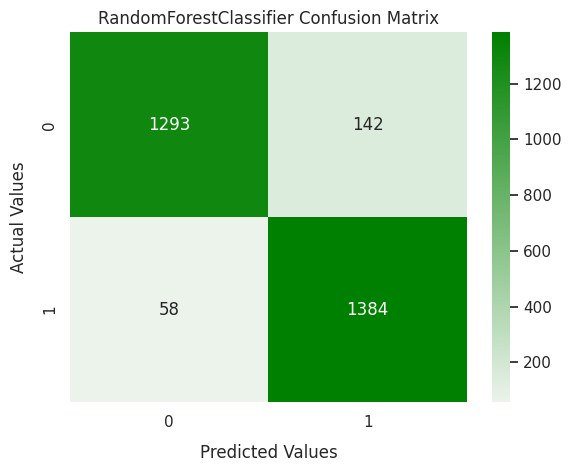

In [314]:
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)

rf_classifier.fit(X_train_processed, y_train)
# Predict on the test data
y_pred = rf_classifier.predict(X_test_processed)
# Evaluate the model
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_roc_auc = evaluation(rf_classifier.__class__.__name__, y_test, y_pred)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

plot_confusion_matrix(rf_classifier.__class__.__name__, y_test, y_pred)

# ROC AUC
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred)

### 2.4. Support Vector Machine


SVC Accuracy: 93.5697
SVC Precision: 90.0574
SVC Recall: 97.9889
SVC F1 Score: 93.8559
SVC ROC AUC Score: 93.5589

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1435
           1       0.90      0.98      0.94      1442

    accuracy                           0.94      2877
   macro avg       0.94      0.94      0.94      2877
weighted avg       0.94      0.94      0.94      2877



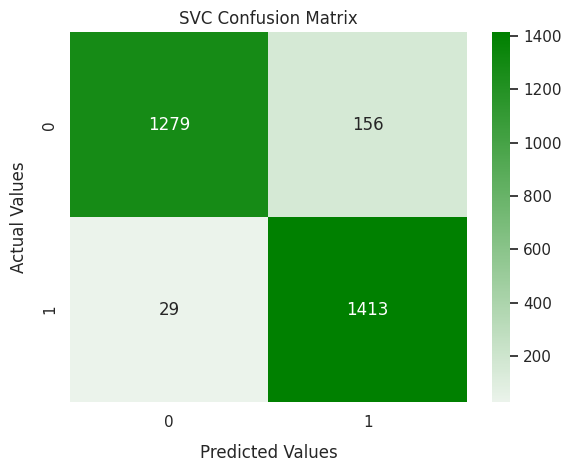

In [315]:
svm_classifier = SVC(random_state=42)

svm_classifier.fit(X_train_processed, y_train)
# Predict on the test data
y_pred = svm_classifier.predict(X_test_processed)
# Evaluate the model
svm_accuracy, svm_precision, svm_recall, svm_f1, svm_roc_auc = evaluation(svm_classifier.__class__.__name__, y_test, y_pred)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

plot_confusion_matrix(svm_classifier.__class__.__name__, y_test, y_pred)

# ROC AUC
svm_fpr, svm_tpr, _ = roc_curve(y_test, y_pred)

### 2.5. XGBoost


XGBClassifier Accuracy: 93.7087
XGBClassifier Precision: 90.1337
XGBClassifier Recall: 98.1969
XGBClassifier F1 Score: 93.9927
XGBClassifier ROC AUC Score: 93.6978

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1435
           1       0.90      0.98      0.94      1442

    accuracy                           0.94      2877
   macro avg       0.94      0.94      0.94      2877
weighted avg       0.94      0.94      0.94      2877



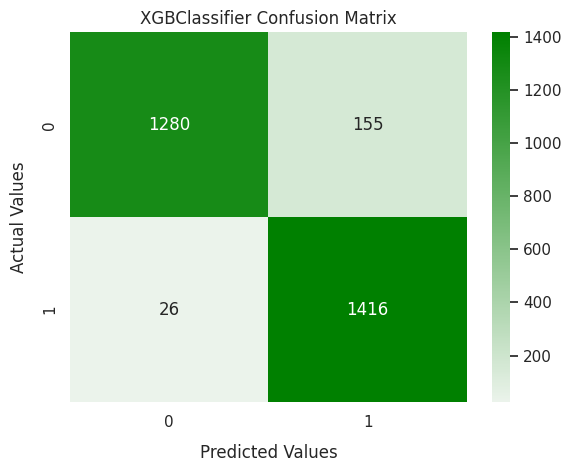

In [316]:
xgb_classifier = XGBClassifier(random_state=42, n_estimators=100, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=3, enable_categorical=True)

xgb_classifier.fit(X_train_processed, y_train)
# Predict on the test data
y_pred = xgb_classifier.predict(X_test_processed)
# Evaluate the model
xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_roc_auc = evaluation(xgb_classifier.__class__.__name__, y_test, y_pred)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

plot_confusion_matrix(xgb_classifier.__class__.__name__, y_test, y_pred)

# ROC AUC
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_pred)

### 2.6. AdaBoost


AdaBoostClassifier Accuracy: 92.0751
AdaBoostClassifier Precision: 91.6896
AdaBoostClassifier Recall: 92.5798
AdaBoostClassifier F1 Score: 92.1325
AdaBoostClassifier ROC AUC Score: 92.0738

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1435
           1       0.92      0.93      0.92      1442

    accuracy                           0.92      2877
   macro avg       0.92      0.92      0.92      2877
weighted avg       0.92      0.92      0.92      2877



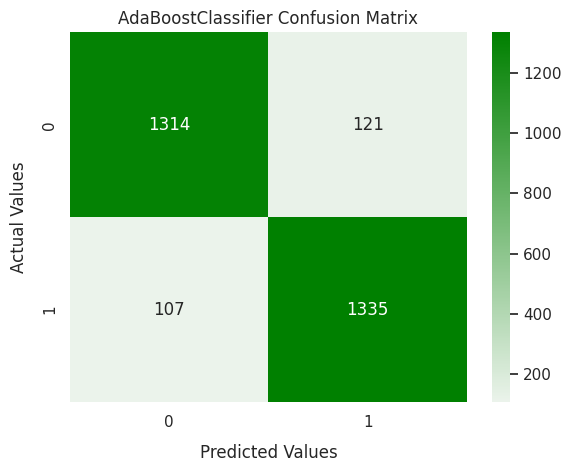

In [317]:
ada_classifier = AdaBoostClassifier(random_state=42, n_estimators=100)

ada_classifier.fit(X_train_processed, y_train)
# Predict on the test data
y_pred = ada_classifier.predict(X_test_processed)
# Evaluate the model
ada_accuracy, ada_precision, ada_recall, ada_f1, ada_roc_auc = evaluation(ada_classifier.__class__.__name__, y_test, y_pred)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

plot_confusion_matrix(ada_classifier.__class__.__name__, y_test, y_pred)

# ROC AUC
ada_fpr, ada_tpr, _ = roc_curve(y_test, y_pred)

## 3. Model Evaluation

In [318]:
eval_data = {
    'Model': ['Decision Tree', 'KNN', 'Random Forest', 'SVM', 'XGBoost', 'AdaBoost'],
    'Accuracy': [dt_accuracy, knn_accuracy, rf_accuracy, svm_accuracy, xgb_accuracy, ada_accuracy],
    'Precision': [dt_precision, knn_precision, rf_precision, svm_precision, xgb_precision, ada_precision],
    'Recall': [dt_recall, knn_recall, rf_recall, svm_recall, xgb_recall, ada_recall],
    'F1-Score': [dt_f1, knn_f1, rf_f1, svm_f1, xgb_f1, ada_f1],
    'ROC AUC': [dt_roc_auc, knn_roc_auc, rf_roc_auc, svm_roc_auc, xgb_roc_auc, ada_roc_auc],
    'fpr': [dt_fpr,knn_fpr,rf_fpr,svm_fpr,xgb_fpr,ada_fpr],
    'tpr': [dt_tpr,knn_tpr,rf_tpr,svm_tpr,xgb_tpr,ada_tpr]}

df_eval_data = pd.DataFrame(eval_data)

In [319]:
def plot_comparison_evaluation(data, metric):
  plt.figure(figsize=(6, 4))
  ax = sns.barplot(x=metric, y='Model', data=data, color='darkcyan')
  ax.bar_label(ax.containers[0], fmt='%.3f')
  ax.set_xlim(0.8, 1.0)
  plt.xlabel(metric)
  plt.ylabel('Model')
  plt.title(f'Comparison of {metric} Across Models')
  plt.tight_layout()
  plt.show()

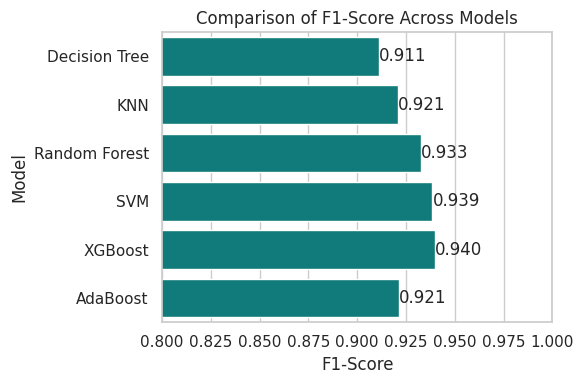

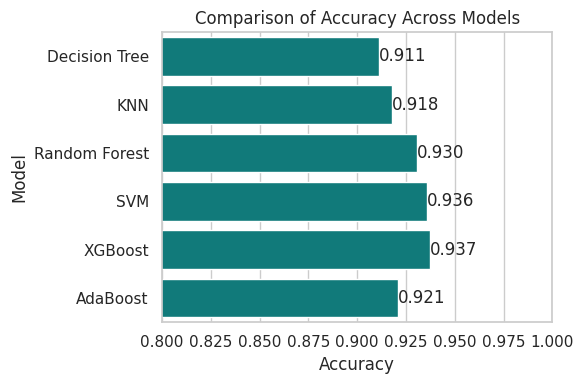

In [320]:
# F1-Score
plot_comparison_evaluation(df_eval_data, metric='F1-Score')
plot_comparison_evaluation(df_eval_data, metric='Accuracy')

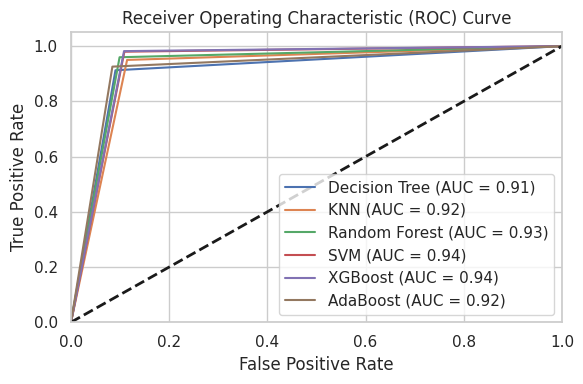

In [321]:
plt.figure(figsize=(6, 4))

for i in df_eval_data['Model'].index:
  model = df_eval_data.iloc[i,0]
  fpr = df_eval_data.iloc[i,6]
  tpr = df_eval_data.iloc[i,7]
  roc_auc = df_eval_data.iloc[i,5]
  plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

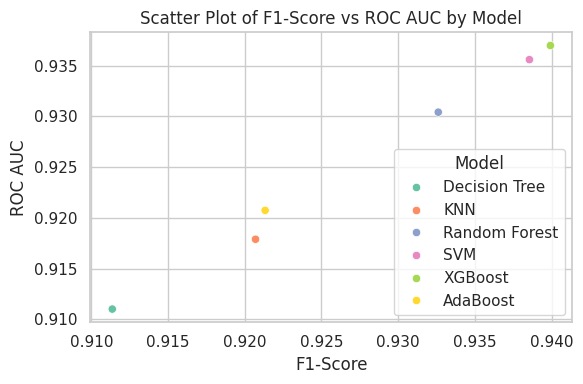

In [322]:
# F1-Score vs ROC AUC
plt.figure(figsize=(6, 4))
sns.scatterplot(x='F1-Score', y='ROC AUC', hue='Model', data=df_eval_data, palette='Set2')
plt.xlabel('F1-Score')
plt.ylabel('ROC AUC')
plt.title('Scatter Plot of F1-Score vs ROC AUC by Model')
plt.legend(title='Model', loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()